In [1]:
import csv
import numpy as np
import math
import pandas as pd
from collections import deque
import copy

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib import animation
import IPython

__requires__= 'networkx==2.5'
import networkx as nx
print("Networkx version: " + nx.__version__)

%matplotlib nbagg

Networkx version: 2.5


# Identifying Communities by Modularity Optimization

Communities in networks can be identified through the minimization of graph modularity.  In the following cells, an algorithm to find communities is implemented for a mock 2-dimensional system.  This is later applied to a 3D chemical system.


The mock 2D system is created as a "ring of rings".  Where pairs of smaller rings are adjusted to sit more adjacent to each other.  This data set is structured this as to create communities of communities in order to properly demonstrated the iterative process of finding "super" communities within a graph.

<IPython.core.display.Javascript object>


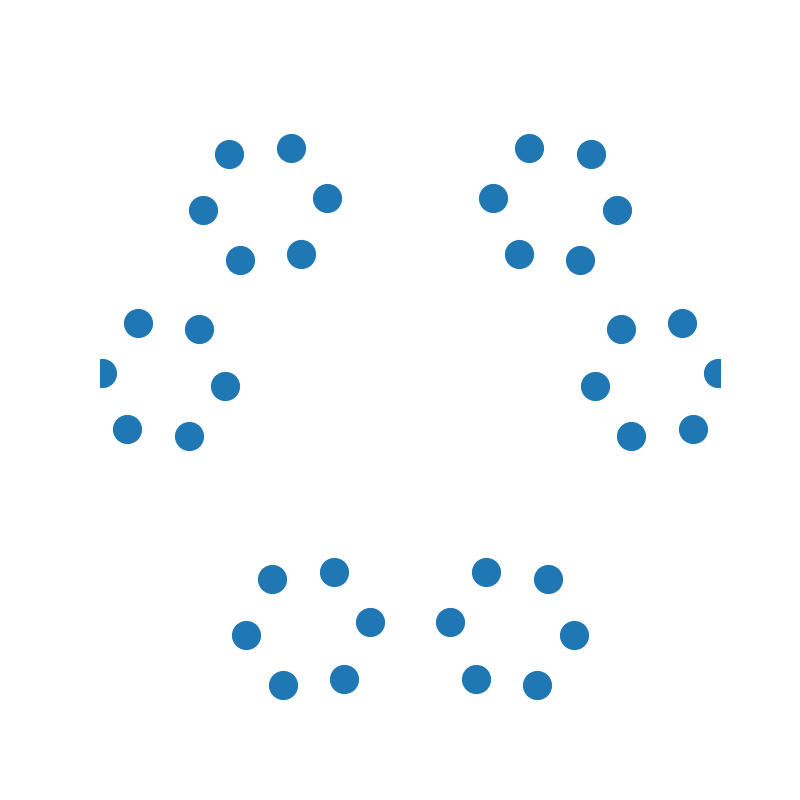

<ipython-input-2-93ddd679ff4b>:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


In [2]:
def create_2D_community(): 
    
    r_outer=2
    r_inner=8

    num_phi_outer=6
    num_phi_inner=6
    
    x=deque()
    y=deque()
    x=np.empty(0)
    y=np.empty(0)

    #create alternating sub cluster distances
    lamda=(2*np.pi)/(num_phi_inner) #wavelength
    A=.1 #magnitude

    phi_outer_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_outer)

    phi_inner_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_inner)
    phi_inner_array+=A*np.cos((phi_inner_array)*np.pi/lamda)

    for phi_outer in phi_outer_array:
        for phi_inner in phi_inner_array:

            x_outer=r_outer*np.cos(phi_outer)+r_inner
            y_outer=r_outer*np.sin(phi_outer)

            r=(x_outer**2+y_outer**2)**(0.5)
            phi=math.atan(y_outer/x_outer)+phi_inner

            x = np.append(x, r*np.cos(phi))
            y = np.append(y, r*np.sin(phi))
    return x,y



x,y = create_2D_community()
# x=x/2
fig_size=8
marker_size=fig_size*50
fig = plt.figure(figsize=(fig_size,fig_size))
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

plt.scatter(x,y, s=marker_size)

# Graph of the 2D System

This function takes the xy data from the 2D system and a user defined distance criteria to create weighted graph.  The graph node attributes are the cartesian coordinates, node color, and a community ID initially set to the node number.  

The graph edges are created for node pairs within the distance criteria and are weighted as the inverse of the euclidean distance.  

In [3]:
def create_primary_graph(x,y,distance_criteria=1.0): 

    graph=nx.Graph()
    
    for i in range(len(x)):
        graph.add_node(i,
                   x_coord = float(x[i]),
                   y_coord = float(y[i]),
                   z_coord = 0,
                   color = 'white',
                   community_ID = i,
                  )


    #add graph edges based on distances
    #weight edges based on inverse distance
    for i in range(len(x)):
        for j in range(len(x)):
            if (i<j):
                xi=graph.nodes[i]['x_coord']
                xj=graph.nodes[j]['x_coord']
                yi=graph.nodes[i]['y_coord']
                yj=graph.nodes[j]['y_coord']
                distance=np.sqrt((xi-xj)**2+(yi-yj)**2)
                
                if ( distance <= distance_criteria):
                    graph.add_edge(i,j,weight = 1/distance)
    return graph
                            
G=create_primary_graph(x,y,distance_criteria=4)

# Plotting

This function colors the nodes in the graph to a user defined color map as a function of community ID.  The minimum and maximum ID's are used to normalize the spread of the cluster ID numbers across the maximum color gradient length.

A set of line segment are also added to visualize the edges in the graph.

Initially, each node has a unique community ID, and so the first graph shows node associations.

In [4]:
def plot_graph(graph: "networkx.classes.graph.Graph", color_map):
    
    text = []

    plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()

    #Map graph node colors to color map
    min=len(graph.nodes())
    max=0
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']<min:
            min=graph.nodes[node]['community_ID']
        if graph.nodes[node]['community_ID']>max:
            max=graph.nodes[node]['community_ID']
    gradientDistance=max-min
    for node in graph.nodes():
        graph.nodes[node]['color']=eval("cm." + color_map + "((graph.nodes[node]['community_ID']-min)/gradientDistance)")




    #plot graph nodes
    for i in range(len(graph.nodes())):
        ax.scatter(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            color= graph.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder=3
        )

        #annotate nodes with community ID number            
        text.append( ax.text(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            graph.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    #plot graph edges as line segments
    segments=deque()
    for i in range(len(graph.edges())):
        u=list(graph.edges)[i][0]
        v=list(graph.edges)[i][1]
        segment=[(
            graph.nodes[u]['x_coord'],
            graph.nodes[u]['y_coord']),(
            graph.nodes[v]['x_coord'],
            graph.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)

<IPython.core.display.Javascript object>


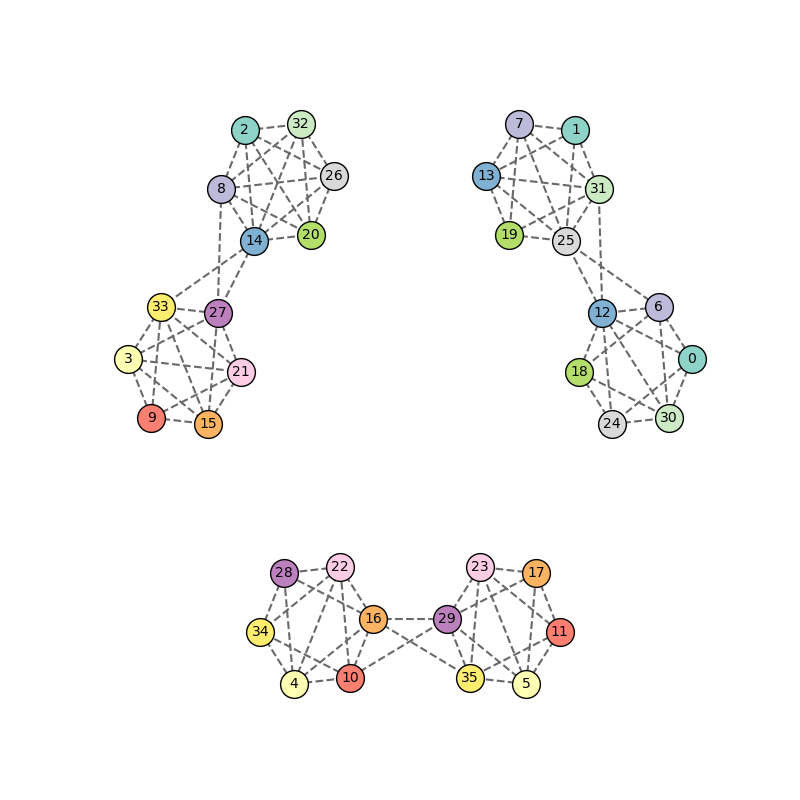

In [5]:
plot_graph(G,'Set3')

# Community Partition

The community partition value to be maximized is given by the product of the graph modularity and a delta function. The graph modularity $X$ is given by the following equation.

$X=\frac{1}{2m}\sum_{ij}{[A_{ij}-\frac{k_ik_j}{2m}]}$ where

$A_{ij}$ is the weight of the edge between $i$ and $j$

$k_i=\sum_jA_{ij}$ is the sum of weights of edges to $i$

$m=\frac{1}{2}\sum_{ij}A_{ij}$

The community partition function Q is then 

$Q=X\delta(c_i,c_j)$ where

$\delta$ is the delta function of $c_i,c_j$ where

$c_i$ is the community of $i$

The following function calculates the community partion for a given graph.

In [6]:
#calculate  Q
def calcQ(graph: "networkx.classes.graph.Graph"):
    X=pd.DataFrame(nx.modularity_matrix(graph))
    print(X)
    Q=0
    for index_i, node_i in enumerate(graph.nodes()):
        for index_j, node_j in enumerate(graph.nodes()):
            if (graph.nodes[node_i]['community_ID']==graph.nodes[node_j]['community_ID']):
                delta_c=1
            if (graph.nodes[node_i]['community_ID']!=graph.nodes[node_j]['community_ID']):
                delta_c=0
            X[index_i][index_j]*=delta_c
            Q+=X[index_i][index_j]
    
    Q/=2*len(graph.edges())
    return Q

# Maximize Q

In first phase of the community partition maximization, nodes are moved to new communitites and the a new partition function is calculated.  If the new Q is greater than the previous value the move to the new community is accepted.  This is performed iteratively over all nodes until the value of Q no longer changes.

In this function, an initial plot of the graph is made, and upon successful movement of a node to a new community, the graph node color and community ID are updated to reflect the change.  At the end of this process the first level of communities are defined, but the larger communities of communities have still not been successfully grouped together.

<IPython.core.display.Javascript object>


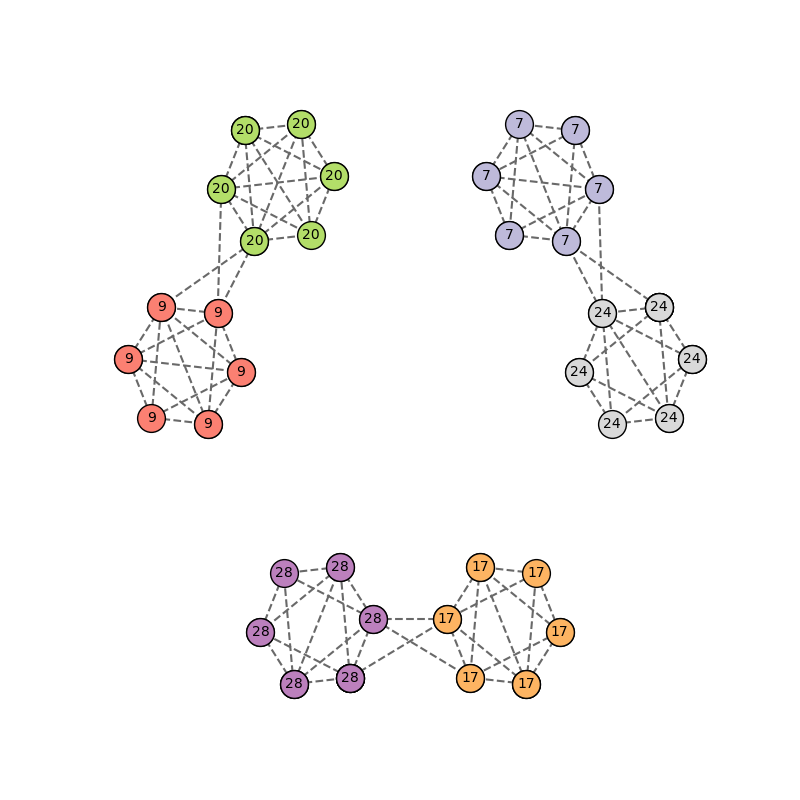

In [460]:
def phase1(graph):
    
#     graph_copy = graph
    graph_copy = copy.deepcopy(graph)
    
    fig_size=8
    marker_size=fig_size*50
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()
    text = []
    
    for i in range(len(graph_copy.nodes())):
        ax.scatter(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            color= graph_copy.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder = 3
        )
        text.append( ax.text(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            graph_copy.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    segments=deque()
    for i in range(len(graph_copy.edges())):
        u=list(graph_copy.edges)[i][0]
        v=list(graph_copy.edges)[i][1]
        segment=[(
            graph_copy.nodes[u]['x_coord'],
            graph_copy.nodes[u]['y_coord']),(
            graph_copy.nodes[v]['x_coord'],
            graph_copy.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)


    
    
    
    convergedQ='NA'
    Q=calcQ(graph_copy)

    while convergedQ != Q:
        convergedQ=Q
        for i in range(len(graph_copy.nodes())):
            for j in nx.neighbors(graph_copy,i):
                origCommunityID=graph_copy.nodes[i]['community_ID']
                C=graph_copy.nodes[j]['community_ID']  #new Community
                if graph_copy.nodes[i]['community_ID']!=C:
                    graph_copy.nodes[i]['community_ID']=C
                    graph_copy.nodes[i]['community_ID']=graph_copy.nodes[j]['community_ID']
                    newQ=calcQ(graph_copy)
                    if (newQ<=Q):
                        graph_copy.nodes[i]['community_ID']=origCommunityID
                    if (newQ>Q):

                        Q=newQ
#                         print(Q)
                        #recolor and relabel node
                        graph_copy.nodes[i]['color']=graph_copy.nodes[j]['color']
                        ax.scatter(
                            graph_copy.nodes[i]['x_coord'],
                            graph_copy.nodes[i]['y_coord'],
                            color= graph_copy.nodes[i]['color'],
                            edgecolors='black',
                            s=marker_size,
                            zorder = 3
                        )
                        text[i].set_text(graph_copy.nodes[i]['community_ID'])
                        fig.canvas.draw()
    return(graph_copy)
                        
H= phase1(G)

# Graph of Super Communities

To find the super communities, a new graph is made in which each node represents a community from the primary graph. These nodes have attributes associated with their community ID and a list of the node numbers in the primary graph that belong to this community ID.

The edges between these new nodes are given by the sum of the weights of the edges between primary graph node members between two communities. 

In [119]:
def create_super_graph(primary_graph): 

    super_graph = nx.Graph()

    #Initialize new graph with node ID's as the clusters from the original graph
    for node in primary_graph.nodes():
        super_graph.add_node(H.nodes[node]['community_ID'],
            community_ID = primary_graph.nodes[node]['community_ID'],
            community_members = [],
            color = primary_graph.nodes[node]['color']
            )

    #Populate each cluster with list of original node members
    for node in primary_graph.nodes():
        super_graph.nodes[primary_graph.nodes[node]['community_ID']]['community_members'].append(node)


    #Find edges between clusters and weight by sum of the two clusters
    for node in primary_graph.nodes():
        for neighbor in (nx.neighbors(primary_graph,node)):
            node_community = primary_graph.nodes[node]['community_ID']
            neigbor_community = primary_graph.nodes[neighbor]['community_ID']
            if node_community != neigbor_community:
                super_graph.add_edge(node_community,neigbor_community, weight = 0)
                super_graph.edges[node_community, neigbor_community]['weight'] += (
                 primary_graph.edges[node,neighbor]['weight'])
                
    return super_graph

H1= copy.deepcopy(H)
super_graph = create_super_graph(H1)

# 

<IPython.core.display.Javascript object>


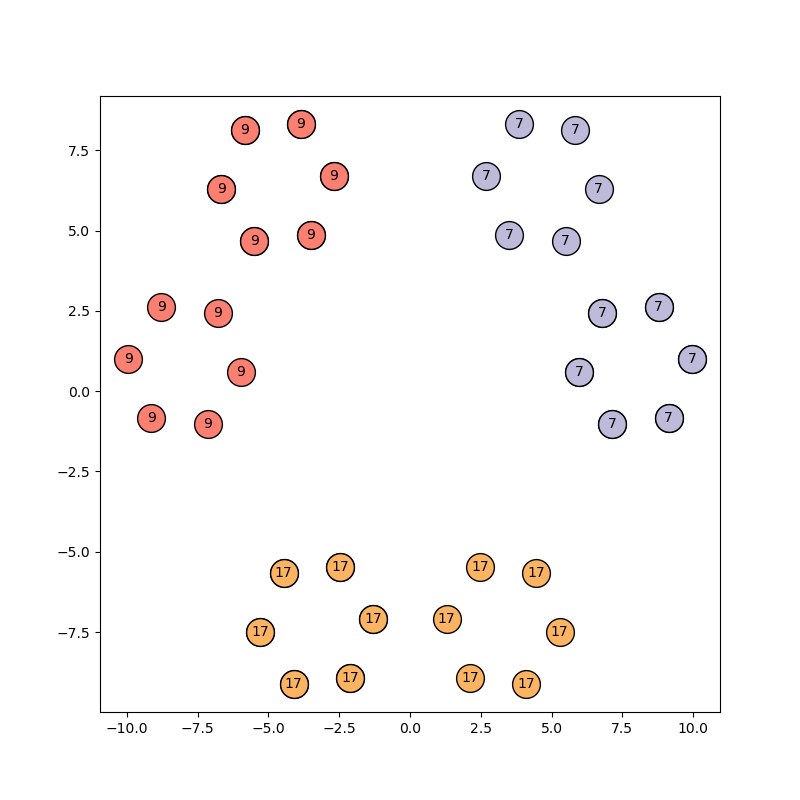

<IPython.core.display.Javascript object>


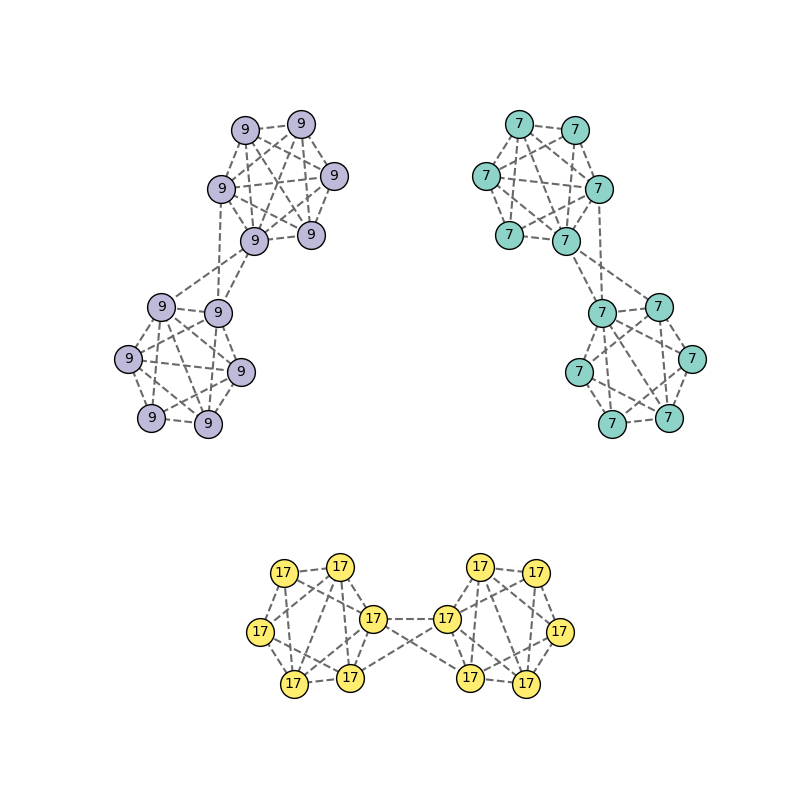

In [120]:
def phase2(primary_graph, super_graph):
    
    primary_graph_copy = copy.deepcopy(primary_graph) #copy of lowest level graph
    super_graph_copy = copy.deepcopy(super_graph) #copy of super community graph

    #plot initial figure
    fig_size=8
    marker_size=fig_size*50
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    text = []
    for node in primary_graph_copy.nodes():
        ax.scatter(
            primary_graph_copy.nodes[node]['x_coord'],
            primary_graph_copy.nodes[node]['y_coord'],
            color= primary_graph_copy.nodes[node]['color'],
            edgecolors='black',
            s=marker_size,
        )
        text.append( ax.text(
            primary_graph_copy.nodes[node]['x_coord'],
            primary_graph_copy.nodes[node]['y_coord'],
            primary_graph_copy.nodes[node]['community_ID'],
            ha='center', va='center'
        ))


    convergedQ='NA'
    Q=calcQ(super_graph_copy)
    while convergedQ != Q:
        convergedQ=Q
        for node in super_graph_copy.nodes():
            for neighbor in nx.neighbors(super_graph_copy,node):
                origCommunityID=super_graph_copy.nodes[node]['community_ID']
                C=super_graph_copy.nodes[neighbor]['community_ID']  #new Community
                if super_graph_copy.nodes[node]['community_ID']!=C:
                    super_graph_copy.nodes[node]['community_ID']=C
                    super_graph_copy.nodes[node]['community_ID']=super_graph_copy.nodes[neighbor]['community_ID']
                    newQ=calcQ(super_graph_copy)
                    if (newQ<=Q):
                        super_graph_copy.nodes[node]['community_ID']=origCommunityID
                    if (newQ>Q):
                        Q=newQ

                        super_graph_copy.nodes[node]['color']=super_graph_copy.nodes[neighbor]['color']

                        #relabel and recolor nodes of lowest level graph to match super graph
                        #properties

                        #update plot of lowest level graph
                        for community_member in super_graph_copy.nodes[node]['community_members']:
                            primary_graph_copy.nodes[community_member]['community_ID']=super_graph_copy.nodes[neighbor]['community_ID']
                            primary_graph_copy.nodes[community_member]['color']=super_graph_copy.nodes[node]['color']
                            ax.scatter(
                                primary_graph_copy.nodes[community_member]['x_coord'],
                                primary_graph_copy.nodes[community_member]['y_coord'],
                                color= primary_graph_copy.nodes[community_member]['color'],
                                edgecolors='black',
                                s=marker_size,
                            )
                            text[community_member].set_text(primary_graph_copy.nodes[community_member]['community_ID'])

                        #update figure
                        fig.canvas.draw()
    return primary_graph_copy

final_graph = phase2(H,super_graph)
plot_graph(final_graph,'Set3')

0
[32, 34, 7, 9, 17, 30]
1
[32, 34, 7, 9, 17, 30]
2
[32, 34, 7, 9, 17, 30]
3
[32, 34, 7, 9, 17, 30]
4
[32, 34, 7, 9, 17, 30]
5
[32, 34, 7, 9, 17, 30]
6
[32, 34, 7, 9, 17, 30]
7
[32, 34, 7, 9, 17, 30]
8
[32, 34, 7, 9, 17, 30]
9
[32, 34, 7, 9, 17, 30]
10
[32, 34, 7, 9, 17, 30]
11
[32, 34, 7, 9, 17, 30]
12
[32, 34, 7, 9, 17, 30]
13
[32, 34, 7, 9, 17, 30]
14
[32, 34, 7, 9, 17, 30]
15
[32, 34, 7, 9, 17, 30]
16
[32, 34, 7, 9, 17, 30]
17
[32, 34, 7, 9, 17, 30]
18
[32, 34, 7, 9, 17, 30]
19
[32, 34, 7, 9, 17, 30]
20
[32, 34, 7, 9, 17, 30]
21
[32, 34, 7, 9, 17, 30]
22
[32, 34, 7, 9, 17, 30]
23
[32, 34, 7, 9, 17, 30]
24
[32, 34, 7, 9, 17, 30]
25
[32, 34, 7, 9, 17, 30]
26
[32, 34, 7, 9, 17, 30]
27
[32, 34, 7, 9, 17, 30]
28
[32, 34, 7, 9, 17, 30]
29
[32, 34, 7, 9, 17, 30]
30
[32, 34, 7, 9, 17, 30]
31
[32, 34, 7, 9, 17, 30]
32
[32, 34, 7, 9, 17, 30]
33
[32, 34, 7, 9, 17, 30]
34
[32, 34, 7, 9, 17, 30]
35
[32, 34, 7, 9, 17, 30]


<IPython.core.display.Javascript object>


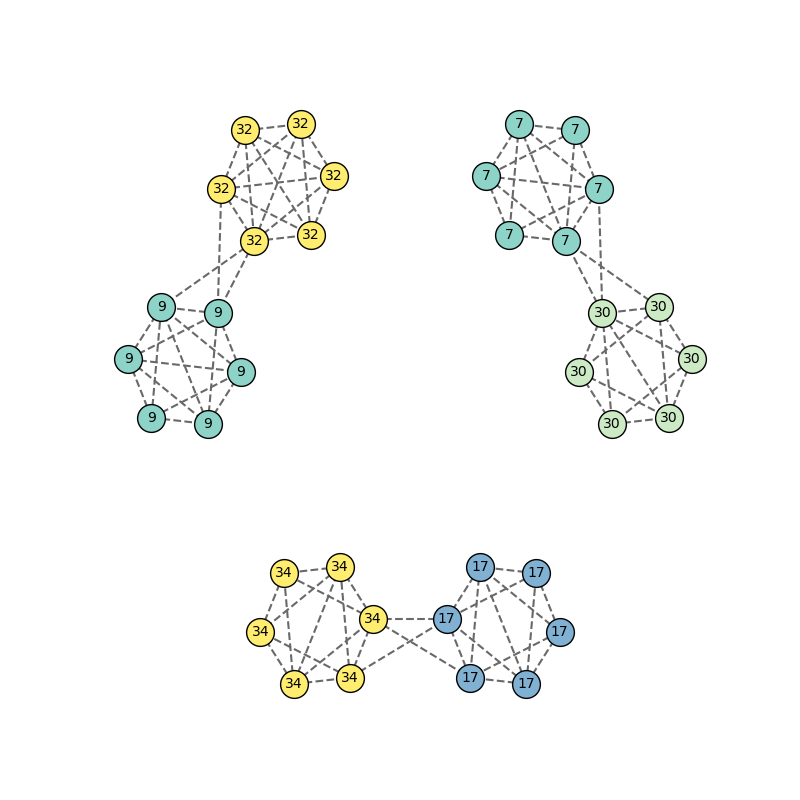

In [295]:
def get_deltaQ(graph: "networkx.classes.graph.Graph", select_node, community_ID):

    ki=0        #sum of the weights of the links incident to node i
    kiin=0      #sum of the weights of the links from i to nodes in a community
    sumIn=0     #sum of weights of edges inside community
    sumTot=0    #sum weights of the links inicident to nodes in community
    m=0         #sum of weights of all edges in network
    
    for index, edge in enumerate(graph.edges(select_node,data=True)):
        ki+=(edge[2]['weight'])
        
        if (graph.nodes[edge[1]]['community_ID'] == community_ID):
            kiin+=(edge[2]['weight'])
            
    #get list of all edges within and incident to community
    edgeList = deque()
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']==community_ID:
            for index, edge in enumerate(graph.edges(node,data=True)):
                sorted_edge=sorted((edge[0],edge[1]))
                sorted_edge.append(edge[2]['weight'])
                edgeList.append(tuple(sorted_edge))
                edgeList = list(set(edgeList))  #remove duplicates

    for edge in edgeList:
        if (graph.nodes[edge[0]]['community_ID'] == community_ID
            and graph.nodes[edge[1]]['community_ID'] == community_ID):
            sumIn+=edge[2]
        if (graph.nodes[edge[0]]['community_ID'] != community_ID
            or graph.nodes[edge[1]]['community_ID'] != community_ID):
            sumTot+=edge[2]
    
    for u, v, weight in graph.edges.data('weight'):
        m+=weight

    
    deltaQ=((sumIn+kiin)/2/m-((sumTot+ki)/2/m)**2)-(sumIn/2/m-(sumTot/2/m)**2-(ki/2/m)**2)

    return deltaQ
    


def group_communities(graph: "networkx.classes.graph.Graph"):
#     convergedQ='NA'
#     Q=calcQ(graph)
#     while Q != convergedQ:
#         convergedQ=Q

    #create set of communities
    community_list = deque()
    for node in graph.nodes():
        community_list.append(graph.nodes[node]['community_ID'])
    community_list = list(set(community_list))

    for node in graph.nodes():
        print(node)
        origCommunityID=graph.nodes[node]['community_ID']
        graph.nodes[node]['community_ID']=len(graph.nodes())+1

        deltaQ = get_deltaQ(graph,node,origCommunityID)
        new_community_ID=origCommunityID

        for community_ID in community_list:
            deltaQ_new = get_deltaQ(graph,node,community_ID)
            if deltaQ_new > deltaQ:
                print(community_ID)
                deltaQ=deltaQ_new
                new_community_ID = community_ID
                
                
        #move node to highest deltaQ community
        graph.nodes[node]['community_ID']=new_community_ID
        
        community_list = deque()
        for node in graph.nodes():
            community_list.append(graph.nodes[node]['community_ID'])
        community_list = list(set(community_list))
        print(community_list)

#         Q=calcQ(graph)
#         print(Q)

# H1 = copy.deepcopy(G)
group_communities(H1)
plot_graph(H1,'Set3')

In [263]:
#import Gromacs data

def get_GROMACS_XYZ_data(timestep, filePath):
    header_df = pd.read_csv(filePath, sep=' ', nrows=2, header=None)
    numAtoms=int(header_df.loc[1, 0])
    headerRows=2
    rowStart = (timestep)*numAtoms+(timestep+1)*headerRows
    timestep_df = pd.read_csv(filePath, delim_whitespace=True, skiprows=rowStart, nrows=numAtoms, header=None, usecols=[1,3,4,5])
    timestep_df.columns = ['AtomType','x_coord','y_coord', 'z_coord']
    #     timestep_df.columns = ['AtomLabel','AtomType','AtomNumber','x_coord','y_coord', 'z_coord','x','y','z']
    return timestep_df

filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/CommunityAnalysis/data/sys_001_npt.gro"


In [408]:
timestep_df = get_GROMACS_XYZ_data(0, filePath)

#remove majority A atoms
timestep_df = timestep_df[~timestep_df['AtomType'].str.contains("B")]
timestep_df = timestep_df[timestep_df['x_coord'] <= 2]
timestep_df = timestep_df[timestep_df['y_coord'] <= 2]
timestep_df = timestep_df[timestep_df['z_coord'] <= 2]
timestep_df = timestep_df.reset_index(drop=True)
print(timestep_df)

   AtomType  x_coord  y_coord  z_coord
0         A    0.692    0.976    0.255
1         A    0.762    1.396    1.927
2         A    0.697    0.326    1.875
3         A    0.600    0.524    1.507
4         A    1.330    0.738    0.835
..      ...      ...      ...      ...
81        A    1.820    0.341    0.293
82        A    1.021    1.606    1.059
83        A    1.858    0.834    0.100
84        A    1.592    1.006    0.383
85        A    1.461    0.380    1.596

[86 rows x 4 columns]


In [375]:
def addNodes(timestep_df, graph: "networkx.classes.graph.Graph"):
    
    for index, row in timestep_df.iterrows():

            graph.add_node(
                index, 
                x_coord = float(timestep_df.loc[index, 'x_coord']),
                y_coord = float(timestep_df.loc[index, 'y_coord']),
                z_coord = float(timestep_df.loc[index, 'z_coord']),
                color='white',
                community_ID = index
            )
            
    return(graph)

def addEdges(timestep_df, graph: "networkx.classes.graph.Graph", distance_criteria):

    for node_u in graph.nodes():
        for node_v in graph.nodes():
            if (node_u<node_v):
                #check for PBC
    #             for cell_x in [-1,0,1]:
    #                 xj=G.nodes[j]['xcoord']+cell_x*boxSize_x
    #                 if (cell_x==0 or abs(xj) <= distanceCriteria):
                        xi=graph.nodes[node_u]['x_coord']
                        xj=graph.nodes[node_v]['x_coord']
                        yi=graph.nodes[node_u]['y_coord']
                        yj=graph.nodes[node_v]['y_coord']

                        distance=np.sqrt((xi-xj)**2+(yi-yj)**2)
                        if ( distance <= distance_criteria):
                            graph.add_edge(node_u,node_v,
                                weight = 1/distance)
    return(graph)


    


In [417]:
#Example usage
LJ=nx.Graph()
LJ=addNodes(timestep_df, LJ)
LJ=addEdges(timestep_df, LJ, 0.86)



<IPython.core.display.Javascript object>


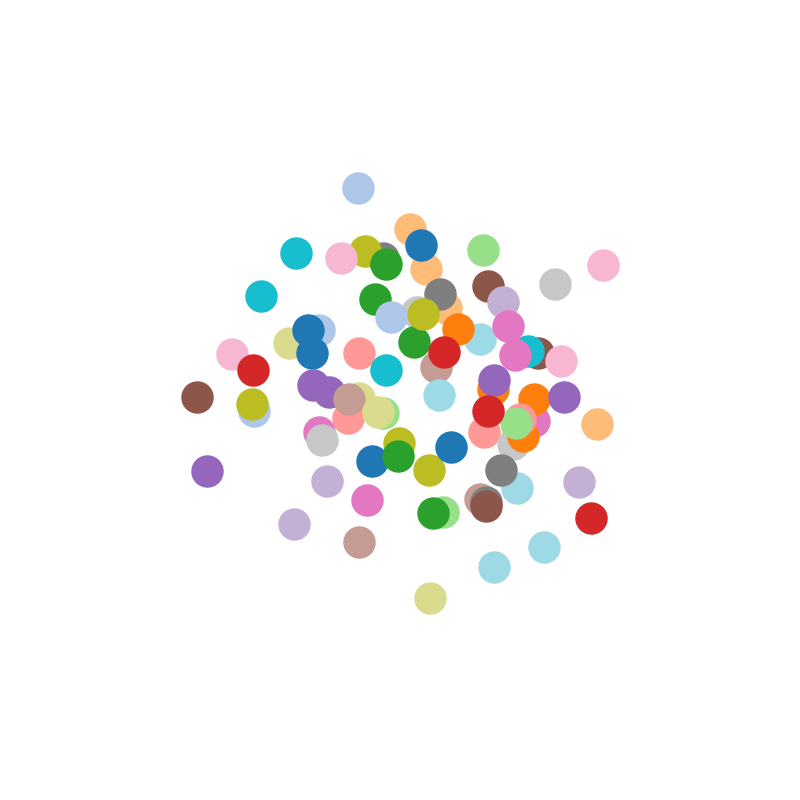

In [418]:
def colorNodes(graph: "networkx.classes.graph.Graph", color_map):
    #get Min and Max community_ID values to bound color gradient
    min=len(graph.nodes())
    max=0
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']<min:
            min=graph.nodes[node]['community_ID']
        if graph.nodes[node]['community_ID']>max:
            max=graph.nodes[node]['community_ID']
    gradientDistance=max-min
    for node in graph.nodes():
#         graph.nodes[node]['color']=cm.tab20((graph.nodes[node]['community_ID']-min)/gradientDistance)
        graph.nodes[node]['color']=eval("cm." + color_map + "((graph.nodes[node]['community_ID']-min)/gradientDistance)")

colorNodes(LJ,'tab20')

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_axis_off()


for node in LJ.nodes():
    ax.scatter(LJ.nodes[node]['x_coord'],
               LJ.nodes[node]['y_coord'],
               LJ.nodes[node]['z_coord'],
               color= LJ.nodes[node]['color'],
               s=500,
              depthshade=True)

In [412]:
def get_deltaQ(graph: "networkx.classes.graph.Graph", select_node, community_ID):

    ki=0        #sum of the weights of the links incident to node i
    kiin=0      #sum of the weights of the links from i to nodes in a community
    sumIn=0     #sum of weights of edges inside community
    sumTot=0    #sum weights of the links inicident to nodes in community
    m=0         #sum of weights of all edges in network
    
    for index, edge in enumerate(graph.edges(select_node,data=True)):
        ki+=(edge[2]['weight'])
        
        if (graph.nodes[edge[1]]['community_ID'] == community_ID):
            kiin+=(edge[2]['weight'])
            
    #get list of all edges within and incident to community
    edgeList = deque()
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']==community_ID:
            for index, edge in enumerate(graph.edges(node,data=True)):
                sorted_edge=sorted((edge[0],edge[1]))
                sorted_edge.append(edge[2]['weight'])
                edgeList.append(tuple(sorted_edge))
                edgeList = list(set(edgeList))  #remove duplicates

    for edge in edgeList:
        if (graph.nodes[edge[0]]['community_ID'] == community_ID
            and graph.nodes[edge[1]]['community_ID'] == community_ID):
            sumIn+=edge[2]
        if (graph.nodes[edge[0]]['community_ID'] != community_ID
            or graph.nodes[edge[1]]['community_ID'] != community_ID):
            sumTot+=edge[2]
    
    for u, v, weight in graph.edges.data('weight'):
        m+=weight

    
    deltaQ=((sumIn+kiin)/2/m-((sumTot+ki)/2/m)**2)-(sumIn/2/m-(sumTot/2/m)**2-(ki/2/m)**2)

    return deltaQ
    


def group_communities(graph: "networkx.classes.graph.Graph"):

    convergedQ='NA'
    Q=calcQ(graph)
    while Q != convergedQ:
        convergedQ=Q

        #create set of communities
        community_list = deque()
        for node in graph.nodes():
            community_list.append(graph.nodes[node]['community_ID'])
        community_list = list(set(community_list))

        for node in graph.nodes():
    #         print(node)
            origCommunityID=graph.nodes[node]['community_ID']
            graph.nodes[node]['community_ID']=len(graph.nodes())+1
            deltaQ = get_deltaQ(graph,node,origCommunityID)
            new_community_ID=origCommunityID

            for community_ID in community_list:
    #             print(community_ID)
                deltaQ_new = get_deltaQ(graph,node,community_ID)
                if deltaQ_new > deltaQ:
    #                 print(community_ID)
                    deltaQ=deltaQ_new
                    new_community_ID = community_ID


            #move node to highest deltaQ community
            graph.nodes[node]['community_ID']=new_community_ID

            community_list = deque()
            for node in graph.nodes():
                community_list.append(graph.nodes[node]['community_ID'])
            community_list = list(set(community_list))
    #         print(community_list)

        Q=calcQ(graph)
        print(Q)


In [420]:
LJH = copy.deepcopy(LJ)

group_communities(LJH)
# calcQ(LJH)

0.02845531506274764
0.061647443184953875
0.08638094502268193
0.09968322645445431
0.11372302733965424
0.11372302733965424


<IPython.core.display.Javascript object>


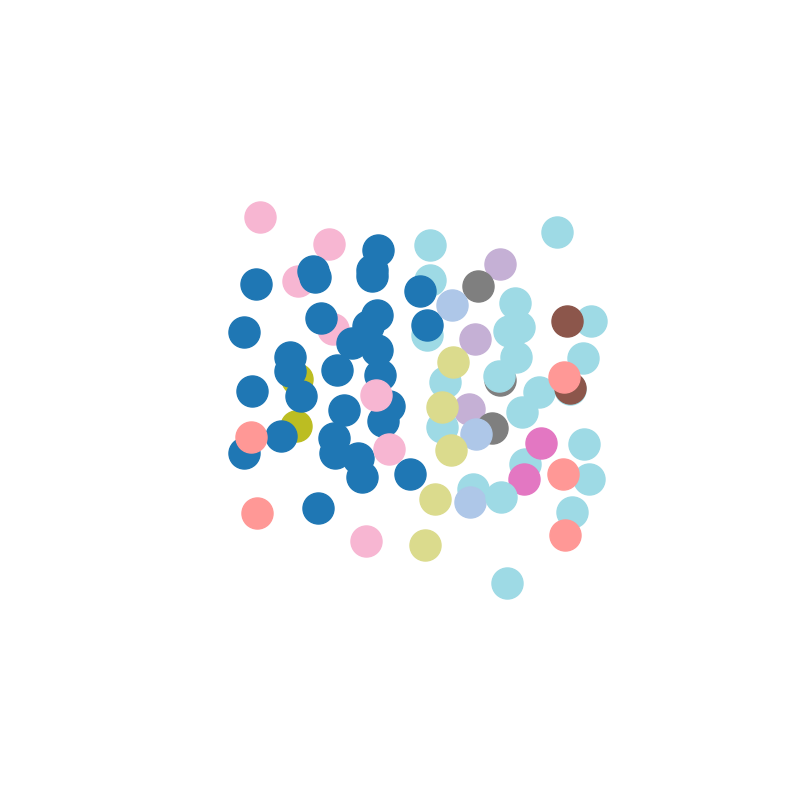

In [421]:
colorNodes(LJH,'tab20')

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_axis_off()


for node in LJH.nodes():
    ax.scatter(LJH.nodes[node]['x_coord'],
               LJH.nodes[node]['y_coord'],
               LJH.nodes[node]['z_coord'],
               color= LJH.nodes[node]['color'],
               s=500,
              depthshade=True)

In [ ]:
create_super_graph()

In [405]:
def create_super_graph(primary_graph): 

    super_graph = nx.Graph()

    #Initialize new graph with node ID's as the clusters from the original graph
    for node in primary_graph.nodes():
        super_graph.add_node(H.nodes[node]['community_ID'],
            community_ID = primary_graph.nodes[node]['community_ID'],
            community_members = [],
            color = primary_graph.nodes[node]['color']
            )

    #Populate each cluster with list of original node members
    for node in primary_graph.nodes():
        super_graph.nodes[primary_graph.nodes[node]['community_ID']]['community_members'].append(node)


    #Find edges between clusters and weight by sum of the two clusters
    for node in primary_graph.nodes():
        for neighbor in (nx.neighbors(primary_graph,node)):
            node_community = primary_graph.nodes[node]['community_ID']
            neigbor_community = primary_graph.nodes[neighbor]['community_ID']
            if node_community != neigbor_community:
                super_graph.add_edge(node_community,neigbor_community, weight = 0)
                super_graph.edges[node_community, neigbor_community]['weight'] += (
                 primary_graph.edges[node,neighbor]['weight'])
                
    return super_graph

H1= copy.deepcopy(H)
super_graph = create_super_graph(H1)


In [406]:
LJ.nodes[1]

{'x_coord': 0.762,
 'y_coord': 1.396,
 'z_coord': 1.9269999999999998,
 'color': 'white',
 'community_ID': 1}

<IPython.core.display.Javascript object>


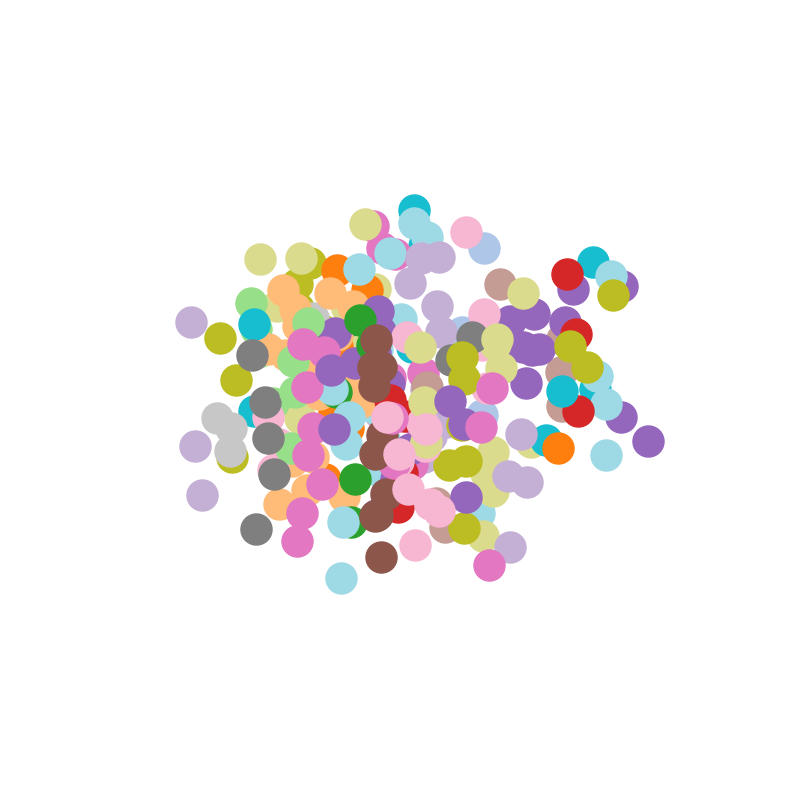

In [407]:
colorNodes(LJH)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_axis_off()


for node in LJH.nodes():
    ax.scatter(LJH.nodes[node]['x_coord'],
               LJH.nodes[node]['y_coord'],
               LJH.nodes[node]['z_coord'],
               color= LJH.nodes[node]['color'],
               s=500,
              depthshade=True)